In [1]:
import yt
import numpy as np

In [2]:
filename = "plt00001"

In [3]:
ds = yt.load(filename)

yt : [INFO     ] 2020-01-28 17:35:26,304 Parameters: current_time              = 0.01
yt : [INFO     ] 2020-01-28 17:35:26,305 Parameters: domain_dimensions         = [21 21 80]
yt : [INFO     ] 2020-01-28 17:35:26,307 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-01-28 17:35:26,307 Parameters: domain_right_edge         = [21. 21. 80.]


yt : [INFO     ] 2020-01-28 17:35:26,449 xlim = 0.000000 21.000000
yt : [INFO     ] 2020-01-28 17:35:26,450 ylim = 0.000000 21.000000
yt : [INFO     ] 2020-01-28 17:35:26,451 xlim = 0.000000 21.000000
yt : [INFO     ] 2020-01-28 17:35:26,451 ylim = 0.000000 21.000000
yt : [INFO     ] 2020-01-28 17:35:26,456 Making a fixed resolution buffer of (('boxlib', 'phi_1_Re')) 800 by 800



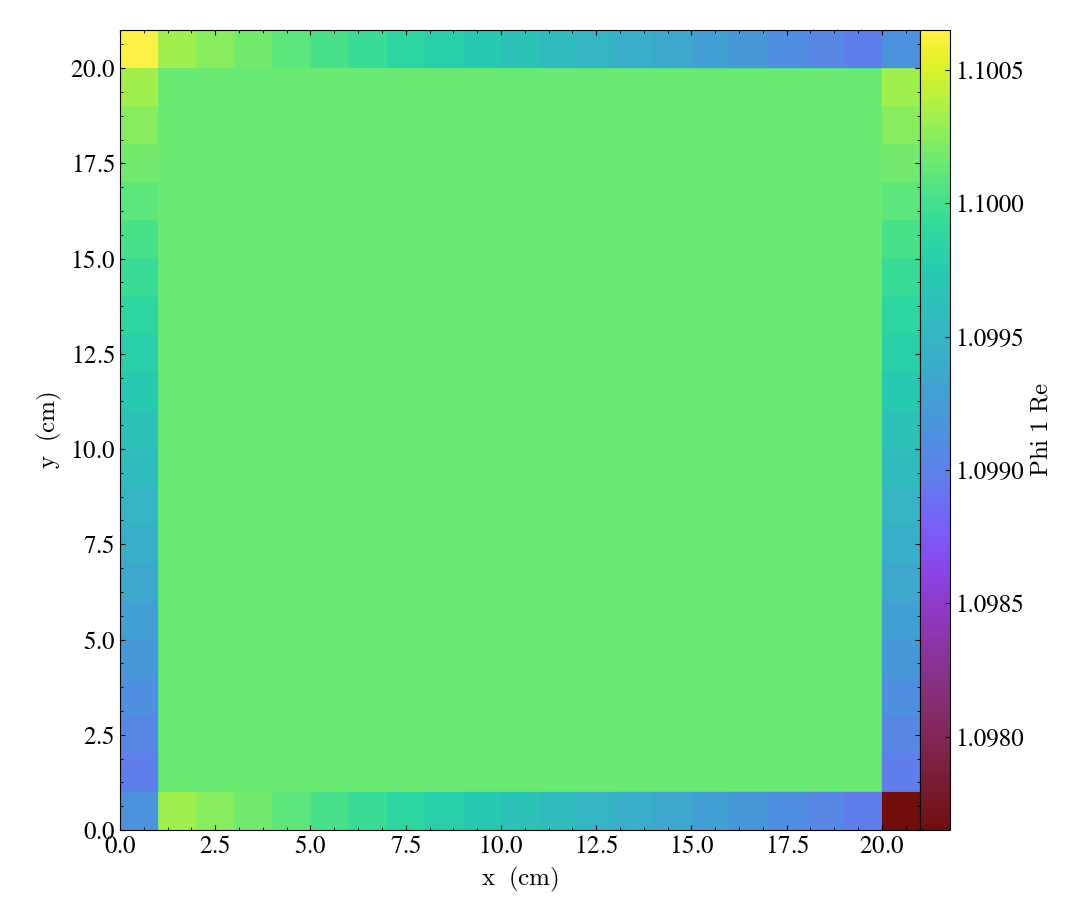

In [4]:
s = yt.SlicePlot(ds, 'z', 'phi_1_Re', origin='native')
s.set_log('phi_1_Re', False)
s.show()

In [5]:
cg = ds.covering_grid(left_edge=ds.domain_left_edge, dims=ds.domain_dimensions, level=0)
coords = cg.fcoords

xs = coords[:,0]
ys = coords[:,1]
ts = coords[:,2]

dx = np.max(xs[1:] - xs[:-1])
dy = np.max(ys[1:] - ys[:-1])
dt = np.max(ts[1:] - ts[:-1])

phi_1_Re = cg["phi_1_Re"][:,:,:].d
phi_1_Im = cg["phi_1_Im"][:,:,:].d
phi_2_Re = cg["phi_2_Re"][:,:,:].d
phi_2_Im = cg["phi_2_Im"][:,:,:].d

In [6]:
def get_fields(i,j,k):
    return phi_1_Re[i,j,k], phi_1_Im[i,j,k], phi_2_Re[i,j,k], phi_2_Im[i,j,k]

In [7]:
def Theta(i, j, k):
    phi_1_Re, phi_1_Im, phi_2_Re, phi_2_Im = get_fields(i, j, k)
    return (phi_1_Im + phi_2_Re)/(phi_1_Re - phi_2_Im)

In [8]:
def Circulation(FTheta):
    center_i = int(ds.domain_dimensions[0]/2)
    center_j = int(ds.domain_dimensions[1]/2)
    center_k = int(ds.domain_dimensions[2]/2)

    radius = 2
    circulation = 0
    
    i_left = center_i - radius
    i_right = center_i + radius
    j_bottom = center_j - radius
    j_top = center_j + radius

    for j in range(ds.domain_dimensions[1]):
        if j >= j_bottom and j < j_top:
            tdiff = FTheta(i_left, j+1, center_k) - FTheta(i_left, j, center_k)
            print("adding ({}, {}): {}".format(i_left, j, tdiff))
            circulation += tdiff

            tdiff = FTheta(i_right, j-1, center_k) - FTheta(i_right, j, center_k)
            print("adding ({}, {}): {}".format(i_right, j, tdiff))
            circulation += tdiff
        elif j == j_top:
            tdiff = FTheta(i_left+1, j, center_k) - FTheta(i_left, j, center_k)
            print("adding ({}, {}): {}".format(i_left, j, tdiff))
            circulation += tdiff

            tdiff = FTheta(i_right, j-1, center_k) - FTheta(i_right, j, center_k)
            print("adding ({}, {}): {}".format(i_right, j, tdiff))
            circulation += tdiff

    for i in range(ds.domain_dimensions[0]):
        if i > i_left and i < i_right:
            tdiff = FTheta(i+1, j_top, center_k) - FTheta(i, j_top, center_k)
            circulation += tdiff
            print("adding ({}, {}): {}".format(i, j_top, tdiff))
            
            tdiff = FTheta(i-1, j_bottom, center_k) - FTheta(i, j_bottom, center_k)
            circulation += tdiff
            print("adding ({}, {}): {}".format(i, j_bottom, tdiff))

    circulation = circulation/(8. * np.arctan(1.0))

    print("circulation = {}".format(circulation))
    return circulation

In [9]:
Circulation(Theta)

adding (8, 8): 0.00029880478087207507
adding (12, 8): -0.0004980079681260463
adding (8, 9): 9.960159362520926e-05
adding (12, 9): -0.00029880478087207507
adding (8, 10): -9.960159362520926e-05
adding (12, 10): -9.960159362520926e-05
adding (8, 11): -0.00029880478087207507
adding (12, 11): 9.960159362520926e-05
adding (8, 12): 0.00029880478087207507
adding (12, 12): 0.00029880478087207507
adding (9, 12): 9.960159362520926e-05
adding (9, 8): -0.00029880478087207507
adding (10, 12): -9.960159362520926e-05
adding (10, 8): -9.960159362520926e-05
adding (11, 12): -0.00029880478087207507
adding (11, 8): 9.960159362520926e-05
circulation = -0.0001268166877216927


-0.0001268166877216927

In [10]:
def read_nrrb_logfile(filename):
    # Read lattice save file
    f_compare = open(filename, "r")

    # Read 2 header lines
    f_compare.readline()
    f_compare.readline()

    # A dictionary for holding the data
    class NrrbData(object):
        def __init__(self, data_dict):
            self.data = data_dict
            
        
    data_compare = {}

    # Read cell & field values from file
    for l in f_compare:
        ls = l.strip().split()
        coords = ls[0][1:-1].split(',')
        x = int(coords[0])
        y = int(coords[1])
        t = int(coords[2])
        p1_Re = float(ls[1])
        p1_Im = float(ls[2])
        p2_Re = float(ls[3])
        p2_Im = float(ls[4])
        data_compare[(x,y,t)] = (p1_Re, p1_Im, p2_Re, p2_Im)

    f_compare.close()
    return data_compare

In [11]:
data_nrrb = read_nrrb_logfile("../../field_configs/v4_mu_-0.100_w_0.100_Nx_21_nL_1_field_config.txt")

In [12]:
def nrrb_Theta(i, j, k):
    phi_1_Re, phi_1_Im, phi_2_Re, phi_2_Im = data_nrrb[(i, j, k)]
    return (phi_1_Im + phi_2_Re)/(phi_1_Re - phi_2_Im)

In [13]:
Circulation(nrrb_Theta)

adding (8, 8): 0.0003486055776882324
adding (12, 8): -0.0004482071713134417
adding (8, 9): 4.9800796816157344e-05
adding (12, 9): -0.0003486055776882324
adding (8, 10): -4.9800796816157344e-05
adding (12, 10): -4.9800796816157344e-05
adding (8, 11): -0.0003486055776882324
adding (12, 11): 4.9800796816157344e-05
adding (8, 12): 0.0003486055776882324
adding (12, 12): 0.0003486055776882324
adding (9, 12): 4.9800796816157344e-05
adding (9, 8): -0.0003486055776882324
adding (10, 12): -4.9800796816157344e-05
adding (10, 8): -4.9800796816157344e-05
adding (11, 12): -0.0003486055776882324
adding (11, 8): 4.9800796816157344e-05
circulation = -0.00012681668772225813


-0.00012681668772225813